In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import googlemaps
from os import getenv

gmaps = googlemaps.Client(key=getenv("GMAPS_API_KEY"))

fasttext_vectors = KeyedVectors.load("fastvec.bin")

In [2]:
def calculate_distance_with_google(user1, user2):
    try:
        # Format origins and destinations
        origins = f"{user1['latitude']},{user1['longitude']}"
        destinations = f"{user2['latitude']},{user2['longitude']}"

        # Request distance matrix
        result = gmaps.distance_matrix(origins, destinations, mode="driving")

        # Extract the distance in meters
        distance_meters = result['rows'][0]['elements'][0].get('distance', {}).get('value')

        if distance_meters is not None:
            # Convert meters to kilometers
            return distance_meters / 1000
        else:
            print("Distance data not available.")
            return None
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None
  

In [3]:
def filter_passengers_along_route(driver, passengers, finish_point, pickup_radius):
    """
    Filter passengers that can be picked up along the driver's route to the finish point.
    
    Args:
        driver (dict): Driver details with 'latitude', 'longitude'.
        passengers (list): List of passenger details with 'latitude', 'longitude'.
        finish_point (dict): The event location with 'latitude', 'longitude'.
        pickup_radius (float): Driver's pickup radius in kilometers.
        
    Returns:
        list: Passengers that can be picked up along the route.
    """
    try:
        # Get the route from driver start to finish point using Google Directions API
        driver_start = f"{driver['latitude']},{driver['longitude']}"
        event_location = f"{finish_point['latitude']},{finish_point['longitude']}"
        
        directions = gmaps.directions(driver_start, event_location, mode="driving")
        route_points = [
            (step['start_location']['lat'], step['start_location']['lng'])
            for leg in directions[0]['legs']
            for step in leg['steps']
        ]
        
        valid_passengers = []
        for passenger in passengers:
            passenger_location = (passenger['latitude'], passenger['longitude'])
            
            # Check if the passenger is within the pickup radius of any route point
            for route_lat, route_lng in route_points:
                distance = calculate_distance_with_google(
                    {"latitude": route_lat, "longitude": route_lng},
                    passenger
                )
                if distance <= pickup_radius:
                    valid_passengers.append(passenger)
                    break  # No need to check further route points for this passenger
        
        return valid_passengers
    except Exception as e:
        print(f"Error filtering passengers: {e}")
        return []

In [5]:
driver = {"name": "Driver1", "latitude": 50.4562, "longitude": 4.8715}  # Charleroi
passengers = [
    {"name": "Alice", "latitude": 50.8503, "longitude": 4.3517},  # Brussels
    {"name": "Bob", "latitude": 51.0278, "longitude": 4.4841},    # Mechelen
    {"name": "Charlie", "latitude": 51.2194, "longitude": 4.4025}  # Antwerp
]
finish_point = {"latitude": 51.2194, "longitude": 4.4025}  # Event in Antwerp
pickup_radius = 10  # 10 km

# Filter passengers along the route
valid_passengers = filter_passengers_along_route(driver, passengers, finish_point, pickup_radius)
print("Passengers along the route:", [p['name'] for p in valid_passengers])

Passengers along the route: ['Charlie']


In [ ]:
calculate_distance_with_google(driver, passengers[0])

67.491

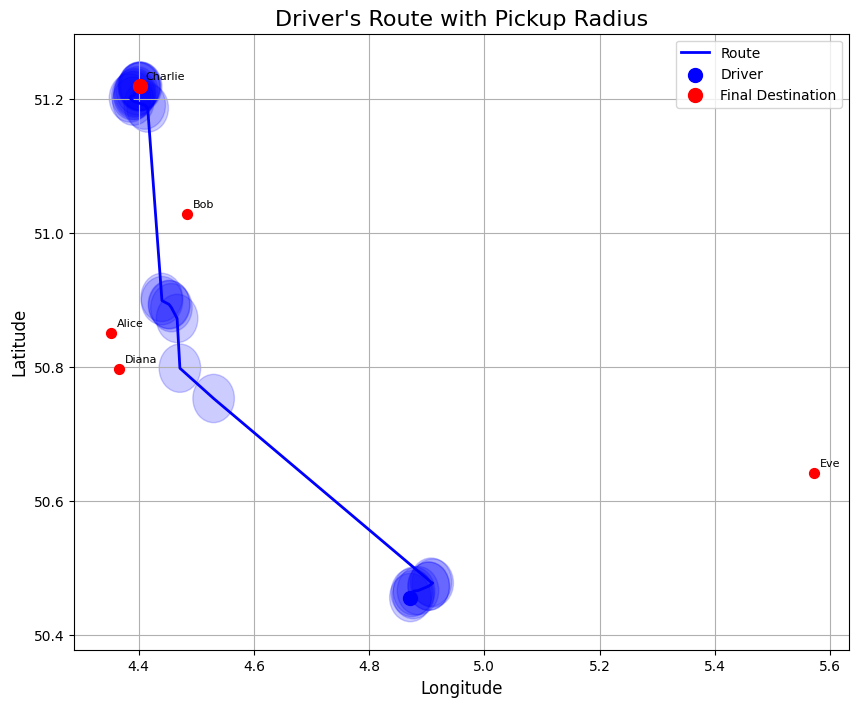

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def get_route_points(driver, finish_point):
    """
    Fetch route points from Google Directions API.
    
    Args:
        driver (dict): Driver's start location with 'latitude' and 'longitude'.
        finish_point (dict): Event location with 'latitude' and 'longitude'.
    
    Returns:
        list: A list of route points as (latitude, longitude).
    """
    driver_start = f"{driver['latitude']},{driver['longitude']}"
    event_location = f"{finish_point['latitude']},{finish_point['longitude']}"
    
    directions = gmaps.directions(
        driver_start,
        event_location,
        mode="driving"
    )
    
    route_points = [
        (step["start_location"]["lat"], step["start_location"]["lng"])
        for leg in directions[0]["legs"]
        for step in leg["steps"]
    ]
    # Include the final destination
    route_points.append((finish_point["latitude"], finish_point["longitude"]))
    
    return route_points


def filter_passengers_by_pickup_radius(passengers, route_points, pickup_radius):
    """
    Filter passengers based on whether they fall within the pickup radius of any route point.
    
    Args:
        passengers (list): List of passengers with latitude and longitude.
        route_points (list): List of tuples representing route coordinates (latitude, longitude).
        pickup_radius (float): Pickup radius in kilometers.
    
    Returns:
        list, list: Two lists of passengers - assigned and outliers.
    """
    assigned = []
    outliers = []
    
    for passenger in passengers:
        assigned_flag = False
        for route_lat, route_lng in route_points:
            distance = calculate_haversine_distance(
                passenger["latitude"], passenger["longitude"],
                route_lat, route_lng
            )
            if distance <= pickup_radius:
                assigned.append(passenger)
                assigned_flag = True
                break
        if not assigned_flag:
            outliers.append(passenger)
    
    return assigned, outliers


def calculate_haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth.
    """
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


def plot_route_with_pickup_radius(driver, assigned_passengers, outlier_passengers, route_points, pickup_radius):
    """
    Plot the driver's route, passengers, and pickup radius on a static map, considering filtering.
    
    Args:
        driver (dict): Driver's details (name, latitude, longitude).
        assigned_passengers (list): List of passengers assigned to the driver.
        outlier_passengers (list): List of passengers not within pickup radius.
        route_points (list): List of tuples representing route coordinates (latitude, longitude).
        pickup_radius (float): Pickup radius in kilometers.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Convert pickup radius to degrees (approximation, assuming 1 degree = 111 km)
    radius_deg = pickup_radius / 111

    # Plot route points as a line
    route_lats, route_lngs = zip(*route_points)
    ax.plot(route_lngs, route_lats, color="blue", linewidth=2, label="Route")

    # Add semi-transparent circles for the pickup radius
    for lat, lng in route_points:
        circle = Circle(
            (lng, lat), radius_deg, color="blue", alpha=0.2
        )
        ax.add_patch(circle)

    # Plot driver start point
    ax.scatter(driver["longitude"], driver["latitude"], color="blue", s=100, label="Driver", zorder=5)

    # Plot assigned passengers
    for passenger in assigned_passengers:
        ax.scatter(
            passenger["longitude"], passenger["latitude"], 
            color="green", s=50, zorder=5
        )
        ax.text(
            passenger["longitude"] + 0.01, passenger["latitude"] + 0.01,
            passenger["name"], fontsize=8
        )

    # Plot outlier passengers
    for passenger in outlier_passengers:
        ax.scatter(
            passenger["longitude"], passenger["latitude"], 
            color="red", s=50, zorder=5
        )
        ax.text(
            passenger["longitude"] + 0.01, passenger["latitude"] + 0.01,
            passenger["name"], fontsize=8
        )

    # Add final destination
    final_dest = route_points[-1]
    ax.scatter(
        final_dest[1], final_dest[0],
        color="red", s=100, label="Final Destination", zorder=5
    )

    # Formatting the plot
    ax.set_title("Driver's Route with Pickup Radius", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True)
    plt.show()


# Example Data
driver = {"name": "Driver1", "latitude": 50.4562, "longitude": 4.8715}  # Charleroi
passengers = [
    {"name": "Alice", "latitude": 50.8503, "longitude": 4.3517},  # Brussels
    {"name": "Bob", "latitude": 51.0278, "longitude": 4.4841},    # Mechelen
    {"name": "Charlie", "latitude": 51.2194, "longitude": 4.4025},  # Antwerp
    {"name": "Diana", "latitude": 50.7965, "longitude": 4.3653},  # Halle
    {"name": "Eve", "latitude": 50.6412, "longitude": 5.5718},    # Liege
]
finish_point = {"latitude": 51.2194, "longitude": 4.4025}  # Event in Antwerp
pickup_radius = 4  # 10 km

# Get the actual route points
route_points = get_route_points(driver, finish_point)

# Filter passengers
assigned_passengers, outlier_passengers = filter_passengers_by_pickup_radius(passengers, route_points, pickup_radius)

# Plot the route and filtered passengers
plot_route_with_pickup_radius(driver, assigned_passengers, outlier_passengers, route_points, pickup_radius)


In [29]:
def group_users_by_driver(driver, assigned_passengers, outlier_passengers):
    """
    Group passengers by the driver and display usable data.
    
    Args:
        driver (dict): Driver's details with 'id' and 'name'.
        assigned_passengers (list): List of passengers assigned to the driver.
        outlier_passengers (list): List of passengers not within pickup radius.
    
    Returns:
        dict: A dictionary of grouped passengers by driver ID.
    """
    # Initialize the group
    grouped_data = {
        "Driver ID": driver.get("name"),
        "Assigned Passengers": [passenger["name"] for passenger in assigned_passengers],
        "Outliers": [passenger["name"] for passenger in outlier_passengers],
    }

    return grouped_data


grouped_data = group_users_by_driver(driver, assigned_passengers, outlier_passengers)


print(grouped_data)
for key, value in grouped_data.items():
    print(f"{key}: {value}")

{'Driver ID': 'Driver1', 'Assigned Passengers': ['Charlie'], 'Outliers': ['Alice', 'Bob', 'Diana', 'Eve']}
Driver ID: Driver1
Assigned Passengers: ['Charlie']
Outliers: ['Alice', 'Bob', 'Diana', 'Eve']


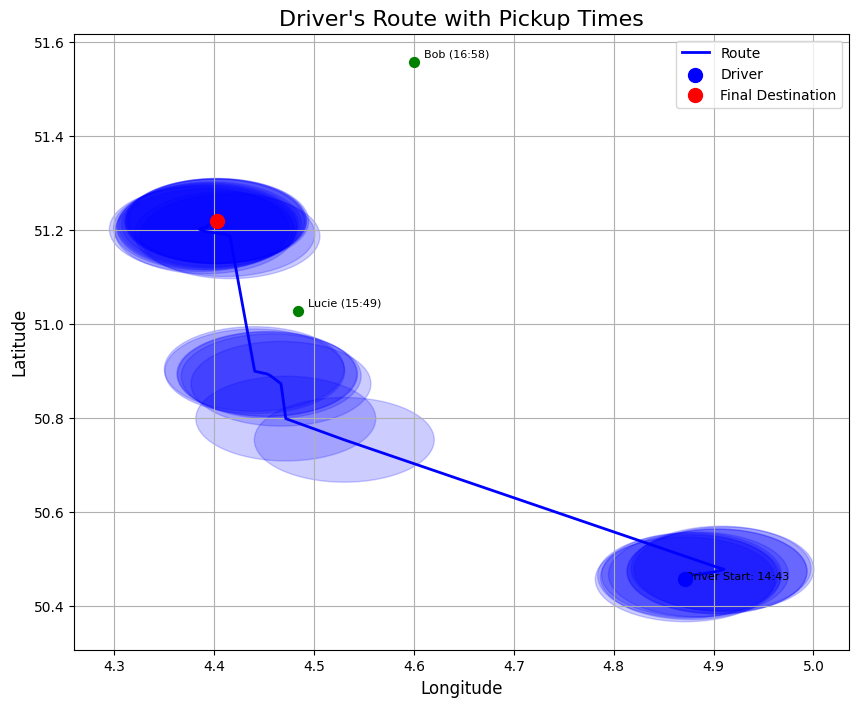

Driver starts at: 14:43
Lucie pickup time: 15:49
Bob pickup time: 16:58


In [43]:
from datetime import datetime, timedelta


def calculate_time_between_points(point1, point2, gmaps):
    """
    Calculate travel time between two points using Google Distance Matrix API.
    """
    response = gmaps.distance_matrix(
        origins=[(point1["latitude"], point1["longitude"])],
        destinations=[(point2["latitude"], point2["longitude"])],
        mode="driving"
    )
    if response["rows"][0]["elements"][0]["status"] == "OK":
        return response["rows"][0]["elements"][0]["duration"]["value"]  # Time in seconds
    return float('inf')  # Return a large value if no route found

def assign_start_times(driver, assigned_passengers, route_points, event_start_time, gmaps):
    """
    Assign start times for the driver and each passenger based on the actual route and stops.
    
    Args:
        driver (dict): Driver's details with 'latitude' and 'longitude'.
        assigned_passengers (list): List of passengers assigned to the driver.
        route_points (list): Ordered list of route points as (latitude, longitude).
        event_start_time (datetime): Event start time.
        gmaps: Google Maps API client.
    
    Returns:
        dict: Dictionary containing start times for the driver and passengers.
    """
    # Forward calculation: calculate total travel time to event
    total_travel_time = 0
    current_time = event_start_time
    passenger_start_times = {}

    # Calculate total travel time including stops
    for idx, passenger in enumerate(assigned_passengers):
        if idx == 0:
            # Travel time from driver to first passenger
            travel_time_to_passenger = calculate_time_between_points(
                {"latitude": driver["latitude"], "longitude": driver["longitude"]},
                {"latitude": passenger["latitude"], "longitude": passenger["longitude"]},
                gmaps
            )
        else:
            # Travel time between consecutive passengers
            previous_passenger = assigned_passengers[idx - 1]
            travel_time_to_passenger = calculate_time_between_points(
                {"latitude": previous_passenger["latitude"], "longitude": previous_passenger["longitude"]},
                {"latitude": passenger["latitude"], "longitude": passenger["longitude"]},
                gmaps
            )
        
        # Add travel time to total and include 5-minute stop
        total_travel_time += travel_time_to_passenger + 300  # 300 seconds = 5 minutes
    
    # Travel time from last passenger to event location
    last_passenger = assigned_passengers[-1]
    travel_time_to_event = calculate_time_between_points(
        {"latitude": last_passenger["latitude"], "longitude": last_passenger["longitude"]},
        {"latitude": route_points[-1][0], "longitude": route_points[-1][1]},
        gmaps
    )
    total_travel_time += travel_time_to_event

    # Adjust driver's start time backward
    driver_start_time = event_start_time - timedelta(seconds=total_travel_time)

    # Assign pickup times for passengers (forward traversal)
    current_time = driver_start_time
    for idx, passenger in enumerate(assigned_passengers):
        if idx == 0:
            # Travel time from driver to first passenger
            travel_time_to_passenger = calculate_time_between_points(
                {"latitude": driver["latitude"], "longitude": driver["longitude"]},
                {"latitude": passenger["latitude"], "longitude": passenger["longitude"]},
                gmaps
            )
        else:
            # Travel time between consecutive passengers
            previous_passenger = assigned_passengers[idx - 1]
            travel_time_to_passenger = calculate_time_between_points(
                {"latitude": previous_passenger["latitude"], "longitude": previous_passenger["longitude"]},
                {"latitude": passenger["latitude"], "longitude": passenger["longitude"]},
                gmaps
            )

        # Assign pickup time and add wait time
        current_time += timedelta(seconds=travel_time_to_passenger)
        passenger_start_times[passenger["name"]] = current_time
        current_time += timedelta(minutes=5)  # Add 5 minutes wait time

    return {
        "driver_start_time": driver_start_time,
        "passenger_start_times": passenger_start_times
    }


def plot_with_start_times(driver, assigned_passengers, route_points, pickup_radius, start_times):
    """
    Plot the driver's route, passengers, and their assigned start times.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Convert pickup radius to degrees (approximation, assuming 1 degree = 111 km)
    radius_deg = pickup_radius / 111

    # Plot route points as a line
    route_lats, route_lngs = zip(*route_points)
    ax.plot(route_lngs, route_lats, color="blue", linewidth=2, label="Route")

    # Add semi-transparent circles for the pickup radius
    for lat, lng in route_points:
        circle = Circle(
            (lng, lat), radius_deg, color="blue", alpha=0.2
        )
        ax.add_patch(circle)

    # Plot driver start point with time
    ax.scatter(driver["longitude"], driver["latitude"], color="blue", s=100, label="Driver", zorder=5)
    ax.text(driver["longitude"], driver["latitude"], f"Driver Start: {start_times['driver_start_time'].strftime('%H:%M')}",
            fontsize=8)

    # Plot assigned passengers with pickup times
    for passenger in assigned_passengers:
        ax.scatter(
            passenger["longitude"], passenger["latitude"],
            color="green", s=50, zorder=5
        )
        ax.text(
            passenger["longitude"] + 0.01, passenger["latitude"] + 0.01,
            f"{passenger['name']} ({start_times['passenger_start_times'][passenger['name']].strftime('%H:%M')})",
            fontsize=8
        )

    # Add final destination
    final_dest = route_points[-1]
    ax.scatter(
        final_dest[1], final_dest[0],
        color="red", s=100, label="Final Destination", zorder=5
    )

    # Formatting the plot
    ax.set_title("Driver's Route with Pickup Times", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True)
    plt.show()


driver = {"name": "Driver1", "latitude": 50.4562, "longitude": 4.8715}  # Charleroi
passengers = [
    {"name": "Lucie", "latitude": 51.0278, "longitude": 4.4841},    # Mechelen
     {"name": "Bob", "latitude": 51.5578, "longitude": 4.6001}
]
finish_point = {"latitude": 51.2194, "longitude": 4.4025}  # Event in Antwerp
pickup_radius = 10  # 10 km
event_start_time = datetime(2025, 1, 13, 18, 0)  # Event at 18:00

# Get the actual route points
route_points = get_route_points(driver, finish_point)

# Assign start times
start_times = assign_start_times(driver, passengers, route_points, event_start_time, gmaps)

# Plot the route with start times
plot_with_start_times(driver, passengers, route_points, pickup_radius, start_times)

print(f"Driver starts at: {start_times['driver_start_time'].strftime('%H:%M')}")
for passenger, time in start_times["passenger_start_times"].items():
    print(f"{passenger} pickup time: {time.strftime('%H:%M')}")